In [34]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['savefig.dpi'] = 125
plt.rcParams['figure.dpi'] = 125

def backtracking_line_search(x0, f, deltaX, df0, alpha=0.1, beta=0.7):
    """ 
    This function implements the backtracking line search method presented in the class
    
    Arguments:
    x0:  the current guess (as a numpy array)
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    deltaX: the descent direction (as a numpy vector)
    df0: the gradient of f at x0 (as a  numpy vector)
    alpha: (optional argument) parameter for the linesearch as defined in class
    beta: (optional argument) parameter for the linesearch as defined in class
    
    Returns: a number between 0 and 1.
    """
    t = 1.
    f0 = f(x0)
    while(f(x0+t*deltaX)>f0 + alpha*t*(df0.dot(deltaX))):
          t = t * beta
    return t    

def gradient_descent(x0, f, df, max_n=1000, tol=10e-10):
    """
    This function implements gradient descent assuming that we have functional expressions
    for f and its gradient. It performs up to max_n iterations and stops when the new vector
    estimate is not improving any more (i.e. |x_old - x_new|<tol)
    
    Note: the stopping criteria is rather naive and could be smarter (cf. book of Boyd for 
    a better stopping criteria) - one should also check that the gradient is close to 0 - otherwise
    it might just mean that the  algorithm is stuck in a poorly conditioned part of the space
    
    Arguments:
    x0: an initial vector to start the minimization from
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    df: the gradient of the function (as a callable function), i.e. df(x0) should work
    max_n: (optional argument) the maximum number of iterations
    tol: (optional argument) the stopping criteria, if |x_old - x_new|<tol then stop
    
    Returns: a numpy 2D array x_steps containing the successive iterations.
             x_steps[0,:] contains x0 and x_steps[-1,:] contains the last estimate of x
    
    """
    x_steps = np.empty([max_n+1, x0.size]) #allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        df_current = df(x_current)
        deltaX = -df_current
        line_search = backtracking_line_search(x_current, f, deltaX, df_current)
        x_current += line_search * deltaX
        x_steps[i+1,:] = x_current

        if np.linalg.norm(x_steps[i,:]-x_current) < tol: #there was no improvement
            break
    if i==max_n-1:
        print("Reached the maximum number of iterations before convergence")
        
    return x_steps[:i+1,:]

def newton_method(x0, f, df, d2f_inv, max_n=1000, tol=10e-10):
    """
    This function implements newton_method assuming that we have functional expressions
    for f and its gradient. It performs up to max_n iterations and stops when the lambda_square goes to 0
    (i.e. |lambda^2|/2<tol)
    
    
    Arguments:
    x0: an initial vector to start the minimization from
    f: the function to minimize (as a callable function), i.e. f(x0) should work
    df: the gradient of the function (as a callable function), i.e. df(x0) should work
    d2f_inv: the hessian matrix of the function
    max_n: (optional argument) the maximum number of iterations
    tol: (optional argument) the stopping criteria, if |x_old - x_new|<tol then stop
    
    Returns: a numpy 2D array x_steps containing the successive iterations.
             x_steps[0,:] contains x0 and x_steps[-1,:] contains the last estimate of x
    
    """
    x_steps = np.empty([max_n+1, x0.size]) #allocate space for the sequence
    x_steps[0, :] = x0
    x_current = x0.copy()
    for i in range(max_n):
        df_current = df(x_current)
        ddf_inverse = d2f_inv(x_current)
        deltaX = -ddf_inverse.dot(df_current)
        line_search = backtracking_line_search(x_current, f, deltaX, df_current)
        x_current += line_search * deltaX
        x_steps[i+1,:] = x_current
        l_2 = np.array(df_current.dot(ddf_inverse)).dot(df_current)/2

        if l_2 < tol: #there was no improvement
            break
    if i==max_n-1:
        print("Reached the maximum number of iterations before convergence")
        
    return x_steps[:i+1,:]

def plot_descent1D(x_steps, x, f):
    """
    plots the function f in the range x and displays the steps in x_steps
    Here we assume that the function has a 1D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x: the range of  values on which to evaluate f
    f: a callable function such that f(x) works
    """
    plt.figure()

    plt.plot(x, f(x), linewidth=2)

    for point in x_steps:
        plt.plot(point, f(point), 'x', markersize=5, markeredgewidth=2)
    plt.xlabel('x')
    plt.ylabel('f(x)')    
        
        
def plot_descent2D(x_steps, x_bounds, y_bounds, f, norm_scale=matplotlib.colors.Normalize()):
    """
    contour plot of the 2D function f in the interval x_bounds and y_bounds and display the steps in x_steps
    Here we assume that the function has a 2D input
    
    Arguments:
    x_steps: the array containing iteration results for a descent algorithm
    x_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate x
    y_bounds: a numpy array or list with two elements, the smallest and largest values over which to evaluate y
    f: a callable function such that f(x) works where x is a 2D vector
    norm_scale: (optional argument) type of color scale to use for display
    """
    plt.figure()
    
    t1 = np.linspace(x_bounds[0], x_bounds[1], 100)
    t2 = np.linspace(y_bounds[0], y_bounds[1], 100)
    tX, tY = np.meshgrid(t1, t2)
    
    f_eval = np.empty_like(tX)
    
    it = np.nditer(tX, flags=['multi_index'])
    while not it.finished:
        f_eval[it.multi_index] = f(np.array([tX[it.multi_index], tY[it.multi_index]]))
        it.iternext()
    
    plt.contourf(tX, tY, f_eval, alpha=.75, cmap='jet', norm=norm_scale)

    plt.plot(x_steps[:,0], x_steps[:,1], '-rx', markersize=5, markeredgewidth=2, linewidth=2)


def compare_convergence(x_steps, p0, fig=None):
    """
    For each row of x_steps, plots its distance p0 (a numpy vector)
    It uses a logarithmic axis for y to show large changes of errors
    
    Arguments:
    x_steps: a 2D numpy array containing iterations of the optimizer
    p0: the optimal point to compare with
    fig: (optional) if given, the plot will be done using figure fig instead of creating a new figure 
        useful to overlay several iterations (e.g. to compare gradient descent and Newton's method)
    """
    
    if fig==None:
        fig = plt.figure()
    else:
        plt.figure(fig.number)
        
    rel_error = x_steps - p0
    plt.semilogy(range(len(x_steps[:,0])),np.linalg.norm(rel_error, axis=1))
    plt.xlabel('Number of iterations')
    plt.ylabel('Relative distance to p0')
    return fig


The minimized function $$f(x) = \mathrm{e}^{\frac{x^2}{100}}$$ gradient $$\frac{df}{dx} = \frac{x}{50}\mathrm{e}^{\frac{x^2}{100}}$$
The second derivative $$\frac{ddf}{dx} = \frac{(x^2+50)}{2500}\mathrm{e}^{\frac{x^2}{100}}$$


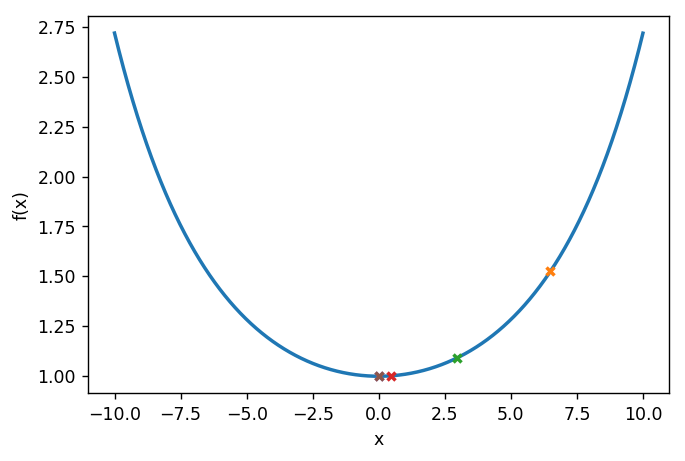

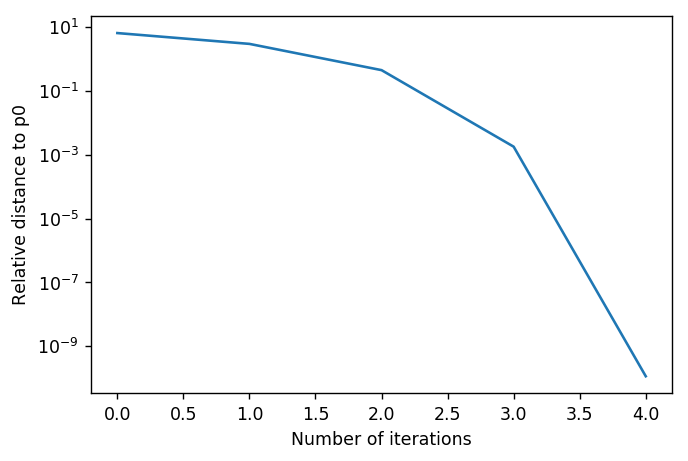

In [35]:
f = lambda x: np.exp(x**2 / 100.)  # lambda function defining f(x)
df = lambda x: (x/50.)*np.exp(x**2 /100.) # lambda function defining df/dx
d2f_inv = lambda x: np.array((1/(1/50.+x**2/2500.))*np.exp(-x**2 / 100.))

# initialization
x_0 = np.array([6.5])
# print(type(d2f_inv(x_0)))

# newton method
x_newton = newton_method(x_0, f, df, d2f_inv)    

# plot functions from x=-10 to x=10
x = np.arange(-10.,10.,0.001)
plot_descent1D(x_newton, x, f)

# compare to theoretical convergence point x = 0
fig = compare_convergence(x_newton, np.array([0.]))

The minimized function $$f(x) = \ x^T \begin{bmatrix}10&1\\1&10 \end{bmatrix}x$$ and its gradient is $$\frac{df}{dx} = 2 \begin{bmatrix}10&1\\1&10 \end{bmatrix}x$$
Hessian : $$\frac{ddf}{dx} = 2 \begin{bmatrix}10&1\\1&10 \end{bmatrix}$$
Inverse of Hessian :  $$ \frac{1}{2*99} *\begin{bmatrix}10&-1\\-1&10 \end{bmatrix}$$

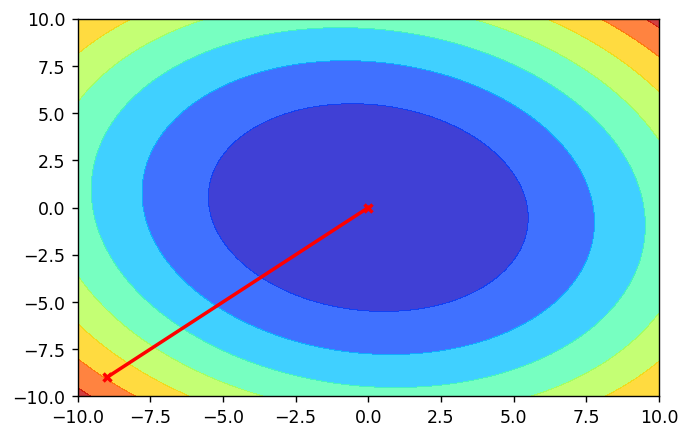

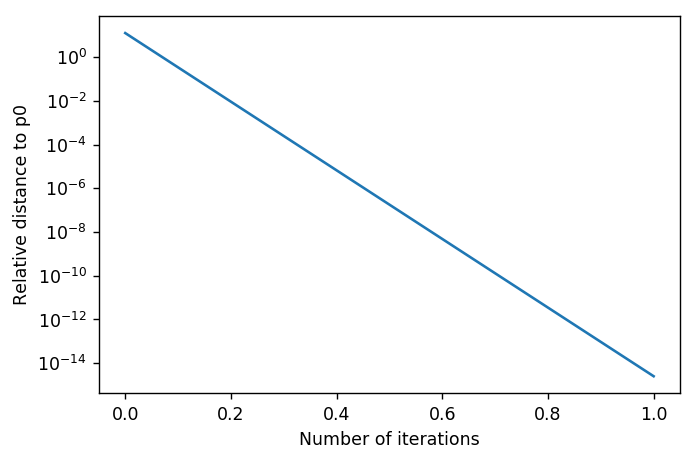

In [36]:
f = lambda x: x.dot(np.array([[10,1],[1,10]])).dot(x) # lambda function defining f(x)
df = lambda x: 2*np.array([[10.,1.],[1.,10.]]).dot(x) # lambda function defining df/dx
ddf_inv = lambda x: np.array((0.5/99.)*np.array([[10.,-1.],[-1.,10.]]))

# initialization
x_0 = np.array([-9., -9.])        
       
# gradient descent    
x_newton = newton_method(x_0, f, df, ddf_inv) 

# plot the newton steps within a [-10,10]x[-10,10] box
plot_descent2D(x_newton, [-10., 10.], [-10., 10.], f)

# compare final result to the theoretical convergence point x = (0,0)^T
fig = compare_convergence(x_newton, np.array([0.,0.]))

In [ ]:
# comment: Iteration stop while the norm of difference fall into an interval small enough